# **Models**

# Data and Library importation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.helpers import (plot_column, plot_increase_five_years, plot_feature_importances)
import polars as pl
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from prophet import Prophet
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings('ignore')

In [5]:
df_combined_inner = pd.read_csv('./data/df_combined_inner.csv', index_col=0, parse_dates=True)

# Initial visualisations

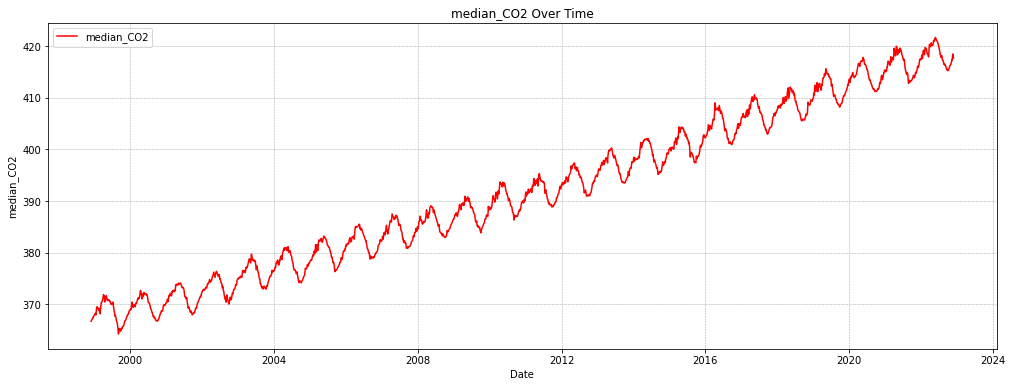

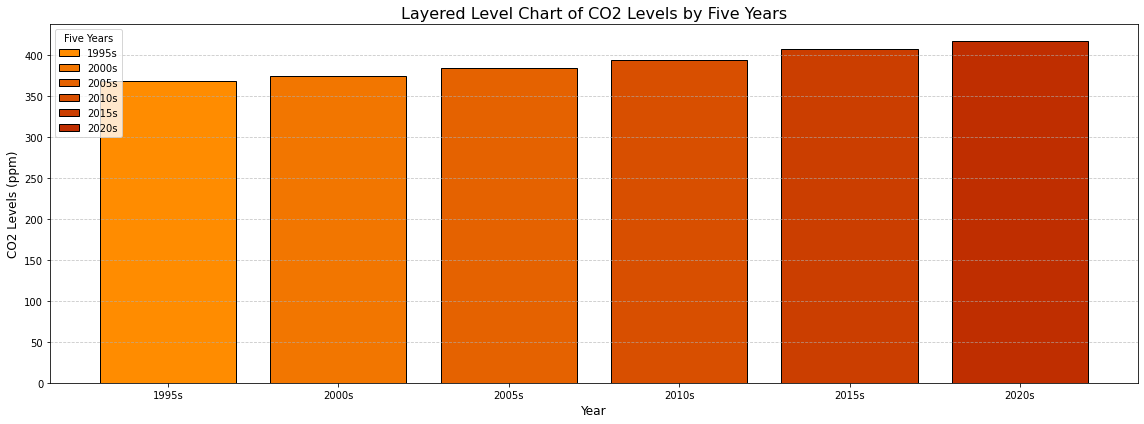

In [6]:
plot_column(df_combined_inner, 'median_CO2', 'red')
plot_increase_five_years(df_combined_inner, 'median_CO2', 'CO2', 'darkorange', 'darkred')

# 1. Long term Model - 10 years ahead - CO2 original data
# **Gaussian Processes**

In [7]:
# Step 1 - resample and structure data

df_CO2_monthly = df_combined_inner.resample('M').mean() # resampling by month
df_CO2_monthly.index = pd.to_datetime(df_CO2_monthly.index, errors='coerce')
df_CO2_monthly['median_CO2'] = df_CO2_monthly['median_CO2'].interpolate(method='time')

In [8]:
# Step 2. Transform datetime into a numeric representation (year + fractional month)
X = df_CO2_monthly.index.year + df_CO2_monthly.index.month / 12
X = X.to_numpy().reshape(-1, 1)  # 2D array for scikit-learn

y = df_CO2_monthly["median_CO2"].to_numpy() # Target variable
 

In [9]:
# Step 3. Create and combine all necessary kernels 

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = ( 
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
) 

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0) 

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [10]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel # combines all kernels

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Gaussian Process Regression uses kernels to define how data points are related. Here we're creating a sophisticated kernel that captures different aspects of CO2 data. 

- `Long-term trend kernel`: Captures slow, gradual changes in CO2 levels
- `Seasonal kernel`: Models annual/cyclical variations
- `Irregularities kernel`: Handles short-term, non-periodic fluctuations
- `Noise kernel`: Accounts for measurement uncertainties

By adding these kernels, we create a comprehensive model that can capture complex patterns in CO2 measurements.

In [11]:
# Step 5. Train the model

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [12]:
# Step 6. Make predictions

# Calculating the last timestamp in your data as "year + fractional month"
last_timestamp = df_CO2_monthly.index.max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12

X_test = np.linspace(start=last_year_fractional, stop=last_year_fractional + 10, num=1_000).reshape(-1, 1)

# Making the predictions
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

We create 1,000 prediction points spanning the next 10 years.


`predict()` returns both the predicted mean and the standard deviation. The standard deviation represents the model's uncertainty at each point.
We add back the mean to convert predictions to absolute CO2 levels for the next 10 years.

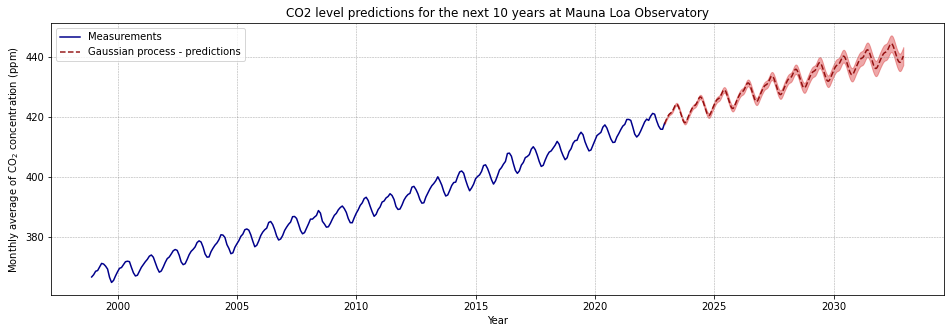

In [13]:
plt.figure(figsize=(16, 5))
plt.plot(X, y, color="darkblue", linestyle="-", label="Measurements")
plt.plot(X_test, mean_y_pred, linestyle="dashed",  color="darkred", alpha=0.9, label="Gaussian process - predictions")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:red",
    alpha=0.4,
)
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7         
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title("CO2 level predictions for the next 10 years at Mauna Loa Observatory")

# 2. Short-Medium Model - predictions 1 month ahead
# **SarimaX**

In [14]:
# Load and prepare the dataset
data = df_combined_inner.copy()
co2_series = data['median_CO2'] # for such a short timeframe we don't really need all the features


In [15]:
# Step 1: Preprocess the data

co2_cleaned = co2_series.interpolate()
co2_diff = co2_cleaned.diff().dropna() # Differencing to remove trends

`diff()` calculates the difference between consecutive observations.

Differencing helps to:

- Remove underlying trends
- Stabilize the variance
- Make the time series more stationary (a key assumption for SARIMA models)

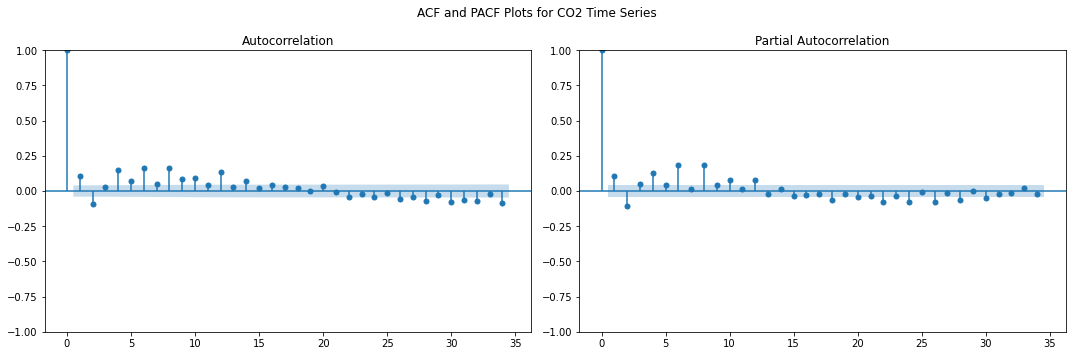

In [16]:
# Step 2: ACF and PACF for diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(co2_diff, ax=ax1)
plot_pacf(co2_diff, ax=ax2)
plt.suptitle('ACF and PACF Plots for CO2 Time Series')
plt.tight_layout()
plt.show()


**ACF** (Autocorrelation Function): Shows correlation between a series and its lagged versions

**PACF** (Partial Autocorrelation Function): Shows direct correlation between observations at different time lags

These plots help determine the appropriate parameters for the SARIMA model

Significant spikes indicate potential autoregressive (p) and moving average (q) terms

In [17]:
# Step 3: finding best SARIMA order using grid search

pdq = [(0, 1, 1), (1, 1, 1), (1, 1, 2)]
seasonal_pdq = [(0, 1, 1, 12), (1, 1, 1, 12), (1, 1, 2, 12)]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(co2_diff, order=param, seasonal_order=seasonal_param)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best SARIMA Order: {best_order + best_seasonal_order}")


Best SARIMA Order: (1, 1, 2, 1, 1, 2, 12)


SARIMA model has multiple parameters:

- `p`: Number of autoregressive terms
- `d`: Degree of differencing
- `q`: Number of moving average terms
- Seasonal parameters add another layer for yearly (or other periodic) patterns


Grid search tests multiple parameter combinations
AIC (Akaike Information Criterion) helps select the best model

Balances model complexity with goodness of fit


The `12` in seasonal parameters suggests annual seasonality

In [18]:
# Step 4: Train the SARIMA model

model = SARIMAX(co2_series, 
                order=best_order, 
                seasonal_order=best_seasonal_order)
model_fit = model.fit()

In [19]:
# Step 5: Forecast next month's CO2 levels

steps = 30
forecast = model_fit.get_forecast(steps=steps)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [20]:
# Step 6: Visualize the extended forecast

historical_range = co2_series.index[-5 * 30:]  # Approximately 5 months

In [21]:
# Forecast dates
forecast_dates = pd.date_range(start=co2_series.index[-1], periods=steps + 1)[1:]

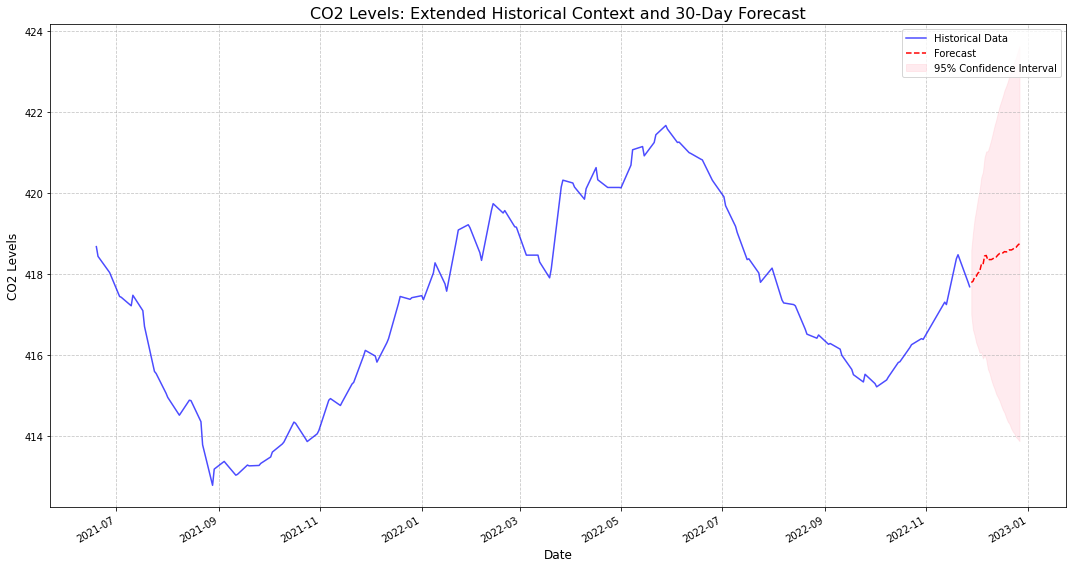

In [22]:
# plot
plt.figure(figsize=(15, 8))

# Plot extended historical data
plt.plot(historical_range, co2_series.loc[historical_range], 
         label='Historical Data', color='blue', alpha=0.7)

# Plot forecast
plt.plot(forecast_dates, predicted_mean, 
         label='Forecast', color='red', linestyle='--')

# confidence interval
plt.fill_between(forecast_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Formatting
plt.title('CO2 Levels: Extended Historical Context and 30-Day Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


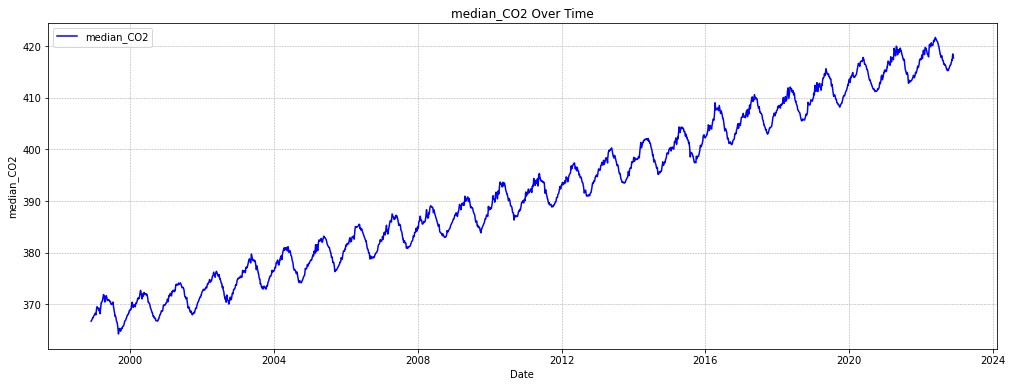

In [23]:
plot_column(df_combined_inner, 'median_CO2', 'blue')

# 3. Medium-Long term Model - predictions 5 years ahead
# **Prophet**

In [24]:
# Step 1. Prepare data

file_path = './data/df_combined_inner.csv'
data = pd.read_csv(file_path, index_col=0, parse_dates=True)
data.reset_index(inplace=True)
prophet_df = data.rename(columns={'index': 'ds', 'median_CO2': 'y'})[['ds', 'y']] # Prophet's required format
prophet_df.dropna(inplace=True)

In [25]:
# Step 2. Add other columns as regressors

other_columns = ['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
                  'evapotranspiration', 'wind_speed', 'soil_temperature','median_CH4' ]  # excluding SF6 and N2O to avoid noise
for column in other_columns:
    prophet_df[column] = data[column]

External regressors allow the model to incorporate additional contextual information. These can improve forecast accuracy by capturing broader environmental behaviours.

In [26]:
# Step 3. Initialize Prophet Model

model = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

# Add regressors
for column in other_columns:
    model.add_regressor(column)

`changepoint_prior_scale`: Controls trend flexibility

Low value (0.05): Minimal sudden changes

Helps prevent overfitting to noise


`seasonality_mode`='multiplicative':

Seasonal variations increase/decrease with the trend

Useful for environmental data where seasonal impacts scale with baseline levels


`interval_width`: Creates 95% confidence intervals

External regressors help the model understand how other factors might influence CO2 levels

In [27]:
# Step 4. Train Prophet model

model.fit(prophet_df)

05:11:48 - cmdstanpy - INFO - Chain [1] start processing
05:11:49 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Step 5. Generate Future Forecast (5 years = ~1825 days)

future = model.make_future_dataframe(periods=5*365)

In [29]:
# Extend regressors into the future
for column in other_columns:
    future[column] = data[column].iloc[-1]  # Use the last known value as a constant
forecast = model.predict(future)

We generate a dataframe with forecasts for the next 5 years (1,825 days).

`model.predict()` generates:
- Point forecasts (yhat)
- Upper and lower confidence intervals


<Figure size 1152x576 with 0 Axes>

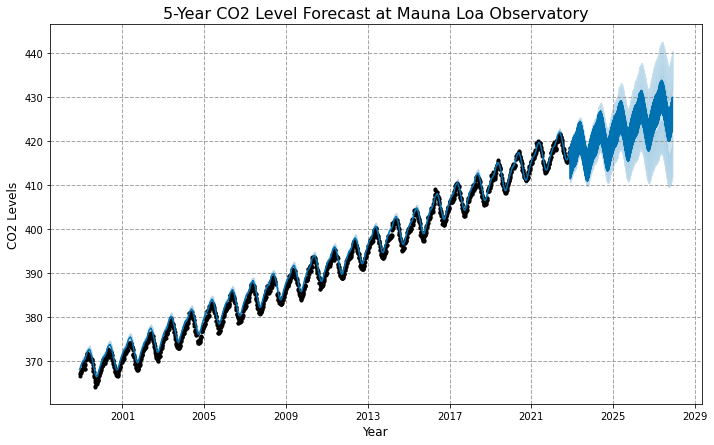

In [30]:
# Step 5. Visualize the Forecast

plt.figure(figsize=(16, 8))
fig = model.plot(forecast)
plt.title('5-Year CO2 Level Forecast at Mauna Loa Observatory', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [31]:
# Analyze Forecast Summary
forecast_summary = {
    'First Predicted Value': forecast['yhat'].iloc[0],
    'Final Predicted Value': forecast['yhat'].iloc[-1],
    'Difference between first and last predicted value': forecast['yhat'].iloc[-1] - forecast['yhat'].iloc[0]
}

print("Forecast Summary:")
for key, value in forecast_summary.items():
    print(f"{key}: {value}")


Forecast Summary:
First Predicted Value: 368.1596018006747
Final Predicted Value: 429.94159020617053
Difference between first and last predicted value: 61.78198840549584


# 4. Long term Model - predictions 20+ years ahead
# **Gaussian Processes** 

In [32]:
# Load dataset
df = pd.read_csv('./data/df_combined_inner.csv', index_col=0, parse_dates=True)
df['datetime'] = pd.to_datetime(df.index)
df.set_index('datetime', inplace=True)

In [33]:
# Step 1. Resample and prepare data

df_monthly = df.resample('M').mean()
df_monthly.interpolate(method='time', inplace=True)
df_monthly.reset_index(inplace=True)

In [34]:
# Step 2. Prepare features and target

X = (df_monthly['datetime'].dt.year + df_monthly['datetime'].dt.month / 12).to_numpy().reshape(-1, 1) # reshape input to 2D array for scikit-learn compatibility
y = df_monthly['median_CO2'].to_numpy()

In [35]:
# Step 3. Standardize target

y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

In [36]:
# Step 4. Kernel creation and selection

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2 
    * RBF(length_scale=100.0) 
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel

Kernel Breakdown:

`Long-term Trend Kernel` (RBF):

- Captures slow, gradual changes in CO2 levels
- Helps model the overall rising trend


`Seasonal Kernel` (RBF * ExpSineSquared):

- Captures annual/cyclical variations
- Models seasonal patterns in CO2 levels


`Irregularities Kernel` (RationalQuadratic):

- Handles short-term, non-periodic fluctuations
- Captures local variations


`Noise Kernel` (RBF + WhiteKernel):

- Accounts for measurement uncertainties
- Helps distinguish between signal and noise

In [37]:
# Step 5. Fit Gaussian Process Regressor

gp = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gp.fit(X, y_normalized)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [38]:
# Step 6. Make predictions

last_timestamp = df_monthly['datetime'].max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12
X_pred = np.linspace(last_year_fractional, last_year_fractional + 20, 240).reshape(-1, 1)

y_pred_normalized, std_pred = gp.predict(X_pred, return_std=True)
y_pred = y_pred_normalized * y_std + y_mean
std_pred *= y_std

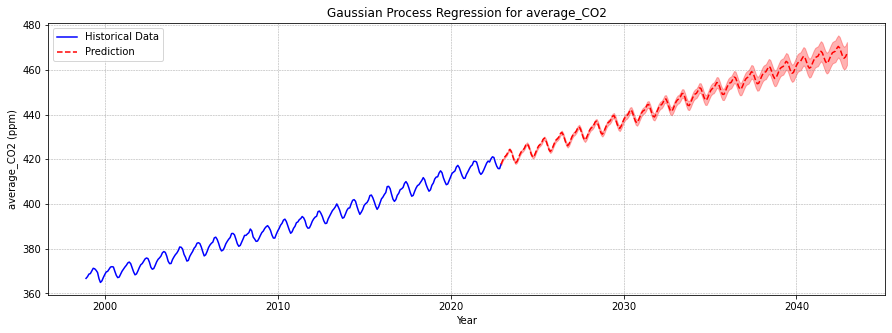

In [39]:
# Step 7. Plot forecast

plt.figure(figsize=(15, 5))
plt.plot(X, y, label='Historical Data', color='blue')
plt.plot(X_pred, y_pred, label='Prediction', color='red', linestyle='--')
plt.fill_between(X_pred.ravel(), y_pred - std_pred, y_pred + std_pred, alpha=0.3, color='red')
plt.title('Gaussian Process Regression for average_CO2')
plt.xlabel('Year')
plt.ylabel('average_CO2 (ppm)')
plt.legend()
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7)
plt.show()

# Visualisations of Feature Importance

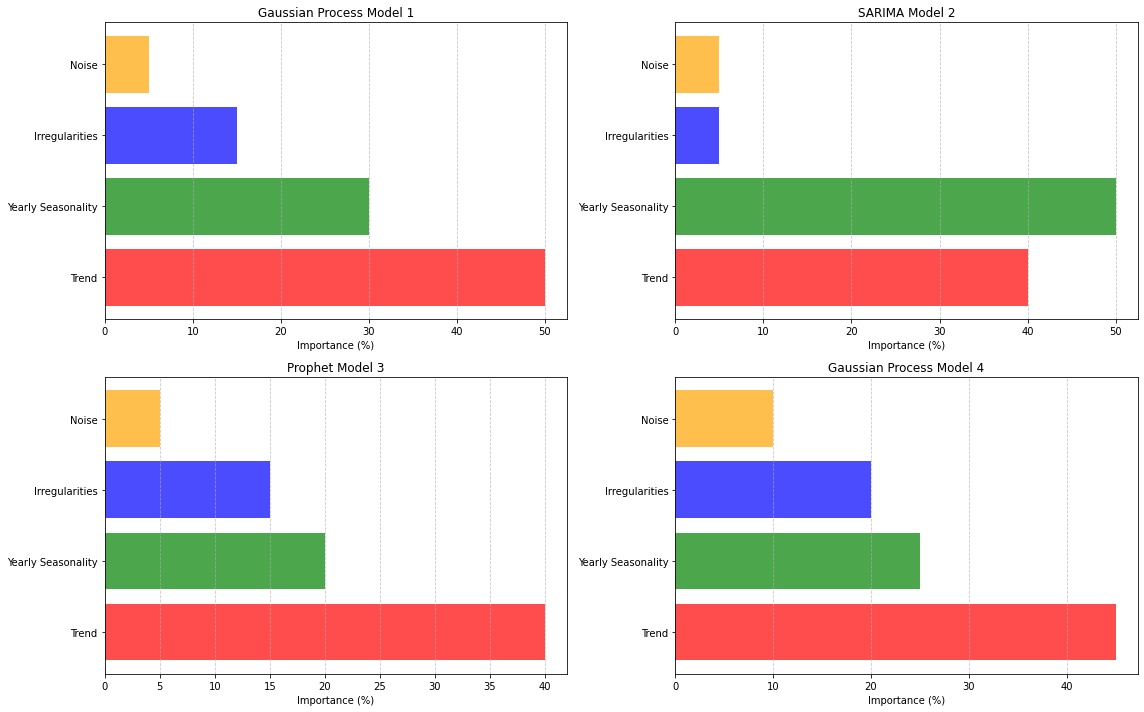

In [40]:

feature_colors = {
    "Trend": "red",
    "Yearly Seasonality": "green",
    "Irregularities": "blue",
    "Noise": "orange",
}

common_features = ["Trend", "Yearly Seasonality", "Irregularities", "Noise"]
importances_list = [
    [50, 30, 15, 5],  # Gaussian Process Model 1
    [40, 50, 5, 5],  # SARIMA Model 2
    [40, 20, 15, 5],  # Prophet Model 3
    [45, 25, 20, 10],  # Gaussian Process Model 4
]
model_titles = [
    "Gaussian Process Model 1",
    "SARIMA Model 2",
    "Prophet Model 3",
    "Gaussian Process Model 4",
]

plot_feature_importances(
    features=common_features,
    importances_list=importances_list,
    model_titles=model_titles,
    feature_colors=feature_colors,
    layout=(2, 2),
    figsize=(16, 10),
)
